# Fast DGSEM block inversion

In this notebook, we test the methods analytical formulations for DGSEM-matrix inversion against classical `numpy` tools. We also time them to see which is the most efficient one.

To test for exactness, we relying on a classical Frobenius norm of the differnce between the proposed analytical formulae and the reference one.

The performances will be measured with `jupyter`/`IPython` `[%]%timeit` magic (see the header of the related cells). To compute fair statistics, we use 20 runs (see option `-r 20`): hence, running the notebook might take some time.

In [1]:
import numpy as np

import fast_DGSEM_block_inversion as f_dgsem

In [2]:
# Polynomial order
p = 2  # Accepted: 1:5 included

# Celerity*time step over spatial grid size
lambda_x, lambda_y = 1.0, 1.0

## Exactness

In [3]:
_ = f_dgsem.compare_eigenvalues_computation(p)

Verification of L eigenvalues (difference inf. norm between the two methods): 2.7599706730399138e-15



In [4]:
_ = f_dgsem.compare_2D_inversion(p, lambda_x, lambda_y)

Verification of diag. block inv. (difference inf. norm between the two methods): 8.060194330240908e-15



In [5]:
_ = f_dgsem.compare_2D_inversion_viscosity(p, lambda_x, lambda_y)

Verification of diag. block inv. with graph visc. (difference inf. norm between the two methods): 2.8937189931735686e-16


## Performances

In [6]:
perf_res = {}  # Store results
for p, lobatto_weights in f_dgsem.LOBATTO_WEIGHTS_BY_ORDER.items():
    print(f"---------------- Assessing order p={p} ----------------")
    # Setting up variables and reusable matrices

    # Derivative matrix
    D = f_dgsem.D_matrix(p)
    # Mass matrix
    M = 0.5 * np.diag(lobatto_weights)
    # Eigen-values and -vectors
    psi = f_dgsem.eigen_L_analytical(D)
    R = f_dgsem.R_matrix(D, psi)
    #temp arrays for numpy inversion
    I = np.eye(p + 1)
    Omega = lobatto_weights.reshape((p + 1, 1))
    IOmega = np.kron(I, Omega)
    OmegaI = np.kron(Omega, I)
    VvT = np.transpose(
        np.concatenate(
            (np.kron(I, np.ones((p + 1, 1))), np.kron(np.ones((p + 1, 1)), I)), axis=1
        )
    )
    #temp arrays for analytical inversion
    invR = np.linalg.inv(R)
    invMR = f_dgsem.diagonal_matrix_multiply(np.reciprocal(np.diag(M)), R)
    invROmega = np.dot(invR, Omega) 
    R2d = np.kron(R, R)
    iR2d = np.kron(invR, invR)
    iMR2d = np.kron(invMR, invMR)
    invRROmega = np.kron(invR, invROmega)
    invROmegaR = np.kron(invROmega, invR)
    # res = %timeit -o captures the result and stores it in res
    res_p = {}
    print("* L2 inversion:")
    print("  - {:10s}: ".format("numpy"), end="")
    res = %timeit -o -r 20 f_dgsem.L2d_inversion_numpy(D, M, lambda_x, lambda_y)
    res_p["L2d_inv_numpy"] = res.average
    print("  - Analytical: ", end="")
    res = %timeit -o -r 20 f_dgsem.L2d_inversion_analytical(D, M, lambda_x, lambda_y, psi, iR2d, iMR2d)
    res_p["L2d_inv_analytical"] = res.average
    print("* L2 inversion with graph viscosity:")
    print("  - {:10s}: ".format("numpy"), end="")
    res = %timeit -o -r 20 f_dgsem.L2d_inversion_viscosity_numpy(D, M, lambda_x, lambda_y, VvT, IOmega, OmegaI)
    res_p["L2d_inv_vis_numpy"] = res.average
    print("  - Analytical: ", end="")
    res = %timeit -o -r 20 f_dgsem.L2d_inversion_viscosity_analytical(D, M, lambda_x, lambda_y, psi, R2d, iR2d, VvT, invRROmega, invROmegaR)
    res_p["L2d_inv_vis_analytical"] = res.average
    
    perf_res[p] = res_p
    print()

---------------- Assessing order p=1 ----------------
* L2 inversion:
  - numpy     : 95.7 µs ± 4.77 µs per loop (mean ± std. dev. of 20 runs, 10,000 loops each)
  - Analytical: 12.4 µs ± 156 ns per loop (mean ± std. dev. of 20 runs, 100,000 loops each)
* L2 inversion with graph viscosity:
  - numpy     : 131 µs ± 2 µs per loop (mean ± std. dev. of 20 runs, 10,000 loops each)
  - Analytical: 60.8 µs ± 1.18 µs per loop (mean ± std. dev. of 20 runs, 10,000 loops each)

---------------- Assessing order p=2 ----------------
* L2 inversion:
  - numpy     : 264 µs ± 103 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
  - Analytical: 15.3 µs ± 51.8 ns per loop (mean ± std. dev. of 20 runs, 100,000 loops each)
* L2 inversion with graph viscosity:
  - numpy     : 301 µs ± 40.7 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
  - Analytical: 130 µs ± 24.5 µs per loop (mean ± std. dev. of 20 runs, 10,000 loops each)

---------------- Assessing order p=3 ----------------
* L

In [7]:
import pandas as pd

In [8]:
perf = pd.DataFrame.from_dict(perf_res, orient="index")
perf["L2d_inv_speed_up"] = perf["L2d_inv_numpy"] / perf["L2d_inv_analytical"]
perf["L2d_inv_vis_speed_up"] = perf["L2d_inv_vis_numpy"] / perf["L2d_inv_vis_analytical"]
perf.index.name = "order"
perf.loc[:, ["L2d_inv_numpy", "L2d_inv_analytical", "L2d_inv_vis_numpy", "L2d_inv_vis_analytical"]] *= 1e6  # From sec to µsec
print("Total results in [µs]:")
perf  # Using default render of jupyter instead of print() for better visualitzation

Total results in [µs]:


,L2d_inv_numpy,L2d_inv_analytical,L2d_inv_vis_numpy,L2d_inv_vis_analytical,L2d_inv_speed_up,L2d_inv_vis_speed_up
order,,,,,,
1,95.659334,12.386514,131.328896,60.791988,7.722861,2.160299
2,264.167668,15.335016,300.961593,129.625122,17.226435,2.321784
3,292.312729,19.172899,455.541413,187.866820,15.246142,2.424810
4,343.782374,24.751313,384.935125,225.709744,13.889460,1.705443
5,402.193946,91.595258,483.875178,388.306520,4.390991,1.246117
6,549.905685,110.953202,500.315234,408.417563,4.956195,1.225009


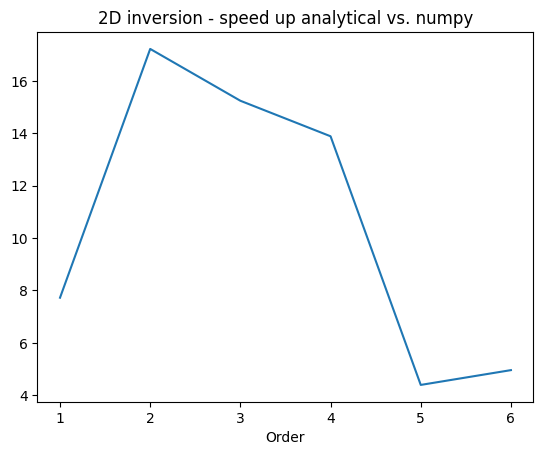

In [9]:
ax = perf.plot(use_index=True, y="L2d_inv_speed_up", legend=False)
_ = ax.set_title("2D inversion - speed up analytical vs. numpy")
_ = ax.set_xlabel("Order")

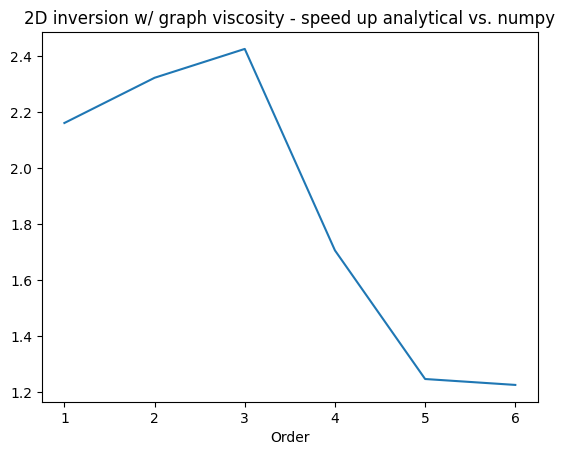

In [10]:
ax = perf.plot(use_index=True, y="L2d_inv_vis_speed_up", legend=False)
_ = ax.set_title("2D inversion w/ graph viscosity - speed up analytical vs. numpy")
_ = ax.set_xlabel("Order")